In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.metrics import r2_score

In [2]:
sns.set(rc={"figure.figsize":(12, 8)})
pd.set_option("display.max_columns", None)

# Import data

In [4]:
data = pd.read_csv('../../tresboncoin/data/master/master_with_fuzzy_and_cleaning.csv')
print(data.shape)
#data = pd.read_csv('master_with_fuzzy_and_cleaning.csv')
data.drop_duplicates(subset=['model_db', 'brand_db', 'price','mileage', 'bike_year'], inplace=True)
#data.drop(columns=['Unnamed: 0'], inplace=True)
print(data.shape)

(27541, 28)
(17929, 28)


# Feature engineering

## Calculated

In [89]:
def km_per_year(km, bike_year):
    if (datetime.now().year- bike_year) == 0:
        return km
    return km / (datetime.now().year- bike_year)

data['km/year'] = data.apply(lambda x: km_per_year(x['mileage'],x['bike_year']), axis=1)

In [90]:
def age(bike_year):
    return datetime.now().year - bike_year

data['age'] = data.bike_year.apply(age)

In [91]:
data = data[data.engine_size<2000]
data = data[data.engine_size>=49]

# Explore data

In [5]:
data.model.nunique()

3623

In [7]:
data.submodel_db.nunique()

2382

## Price
### vs mileage (km) per category

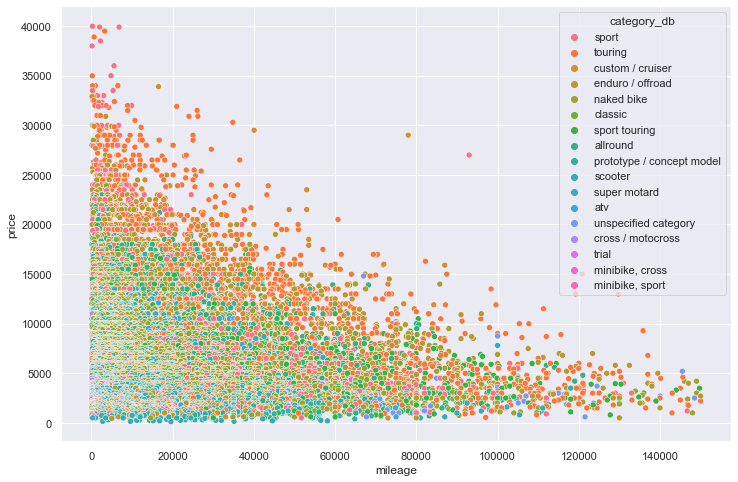

In [8]:
sns.scatterplot(x='mileage', y='price', hue='category_db', data=data);

### vs mileage (km) per engine size

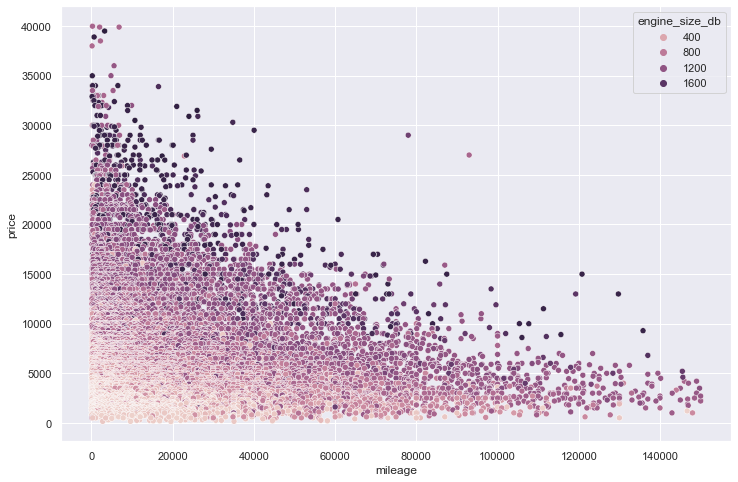

In [10]:
sns.scatterplot(x='mileage', y='price', hue='engine_size_db', data=data);

### vs mileage (km) per power range

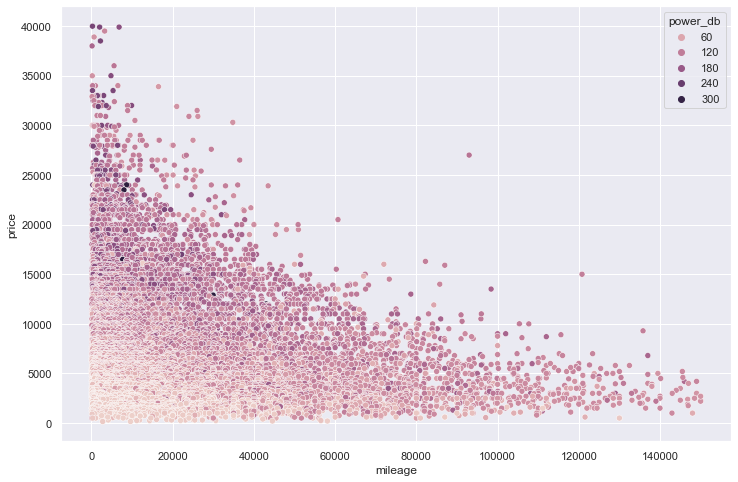

In [11]:
sns.scatterplot(x='mileage', y='price', hue='power_db', data=data);

### vs year of release per category

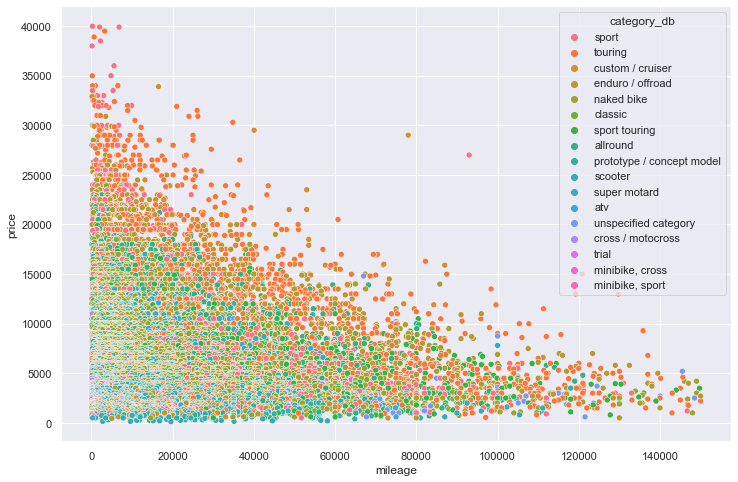

In [13]:
sns.scatterplot(x='mileage', y='price', hue='category_db',data=data);

### vs year of release per engine size

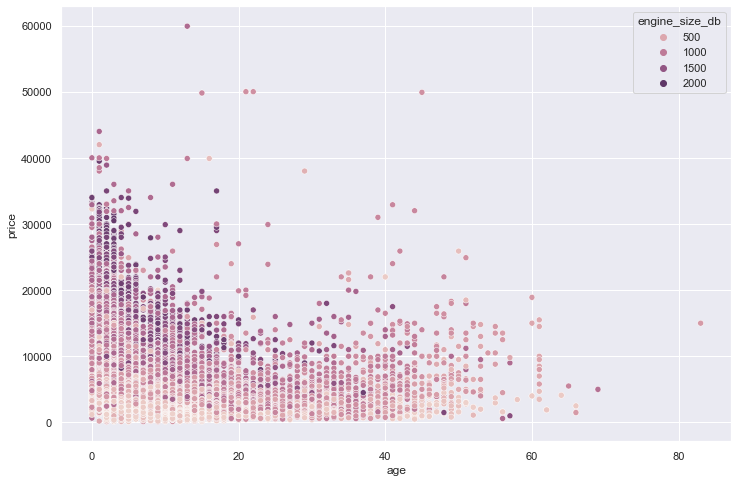

In [13]:
sns.scatterplot(x='age', y='price', hue='engine_size_db', data=data);

### vs km/year

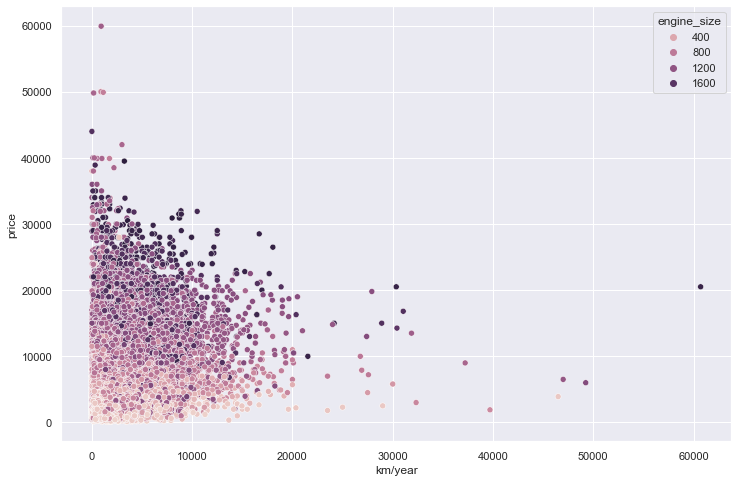

In [14]:
sns.scatterplot(x='km/year', y='price', hue='engine_size',data=data);

### Average price per engine size

In [14]:
data.groupby('engine_size_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

,Mean,Std,Count
engine_size_db,,,
48.9,2990.000000,NaN,1
49.0,1456.530303,744.055007,66
49.1,908.000000,501.318262,5
49.2,2151.117647,1837.037012,17
49.3,1594.451613,758.101745,31
...,...,...,...
1854.0,9247.500000,1898.581707,2
1868.0,27003.157895,5228.518010,19
1868.2,27396.666667,4582.054852,6


In [16]:
#engine_size_count_threshold = 3
#groupby_engine_size = data.groupby('engine_size').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
#groupby_engine_size[groupby_engine_size.Count < 4]
#groupby_engine_size

### Average price per category

In [17]:
data.groupby('category_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

,Mean,Std,Count
category_db,,,
allround,8111.295455,5316.375151,2112
atv,8448.848837,7149.145677,86
classic,8168.198033,4113.243601,1525
cross / motocross,6675.324786,4960.918763,234
custom / cruiser,8577.526316,6534.947228,1254
enduro / offroad,8966.134146,6218.463434,2378
"minibike, cross",6514.628571,4054.440333,35
"minibike, sport",1770.000000,327.108545,5
naked bike,6900.204854,4401.918566,5604


In [18]:
category_count_threshold = 200
groupby_category = data.groupby('category_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
drop_category = groupby_category[groupby_category .Count < category_count_threshold].index.to_list()
drop_category.append('unspecified category')

In [19]:
data = data[data.category_db.isin(drop_category) == False]

### Average price per brand

In [20]:
data.groupby('brand_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

,Mean,Std,Count
brand_db,,,
ace,4290.000000,NaN,1
adler,5546.333333,2033.489693,3
adly,11490.000000,NaN,1
alta,22000.000000,NaN,1
aprilia,7883.784141,5448.870010,227
...,...,...,...
xingyue,8108.333333,4892.346915,3
xmotos,2499.000000,NaN,1
yamaha,6957.655153,5024.748992,3590


In [105]:
brand_count_threshold = 200
groupby_brand = data.groupby('brand_db').agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
drop_brand = groupby_brand[groupby_brand.Count < brand_count_threshold].index.to_list()
data = data[data.brand_db.isin(drop_brand) == False]

### Average price per model

In [22]:
data.groupby(['brand_db','model_db']).agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))

Mean          Std  Count
brand_db model_db                                       
aprilia  atlantic125    10445.000000  5734.635995      2
         atlantic500      896.666667   295.014124      3
         caponord1200    7357.500000  2782.135613      8
         classic125      1300.000000          NaN      1
         dorsoduro1200   9676.818182  6316.723784     11
...                              ...          ...    ...
yamaha   yzfr125         3868.837838  3288.712062     37
         yzfr25          4450.000000   353.553391      2
         yzfr3           4933.800000  1307.439176      5
         yzfr6           5848.687500  2666.531748     16
         yzfr7          49999.000000     0.000000      2

[1840 rows x 3 columns]

In [23]:
#model_count_threshold = 1
#groupby_model = data.groupby(['model_db']).agg(Mean=('price', 'mean'), Std=('price', 'std'), Count=('price', 'count'))
#drop_model = groupby_model[groupby_model.Count < model_count_threshold].index.to_list()
#data = data[data.model_db.isin(drop_model) == False]

## Correlation matrix

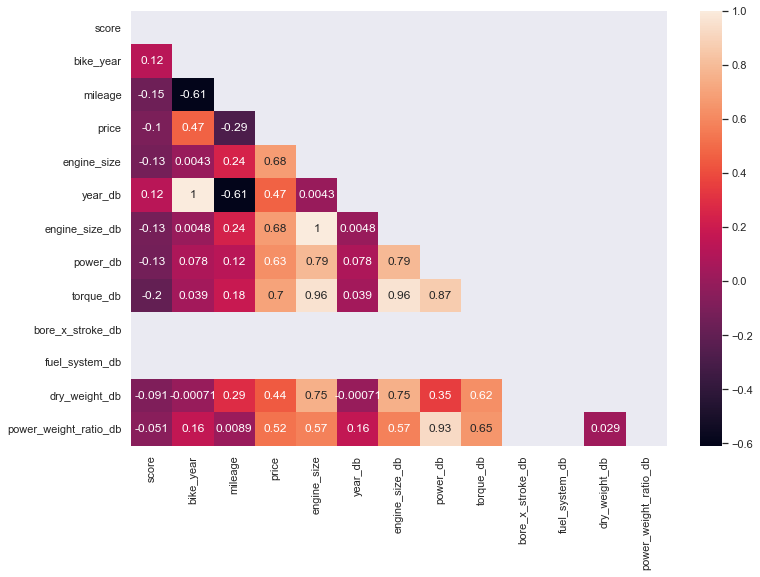

In [15]:
sns.heatmap(data.corr(), annot = True, mask=np.triu(np.ones_like(data.corr(), dtype=bool)));

# BASELINE

## Average

In [25]:
from sklearn.metrics import r2_score

# mean
average_price = data.price.mean()

#rmse
rmse_baseline = np.sqrt(sum((data['price']-average_price)**2)/((data['price'].count())))

print("Average price :", average_price)
print("RMSE Baseline", rmse_baseline )

# r  square
data['y_pred'] = average_price
r2 = r2_score(data.price, data.y_pred)
print("R^2", r2 )

Average price : 7694.106825800272
RMSE Baseline 5561.20085963006
R^2 0.0


## Average per year

In [30]:
average_year = data.groupby(['bike_year']).agg(Mean=('price', 'mean'))

In [48]:
def mean_year(year):
    return average_year[average_year.index == year].max()

data['y_pred2'] = data.bike_year.apply(mean_year)

In [50]:
#rmse
rmse_baseline_2 = np.sqrt(sum((data['price']-data.y_pred2)**2)/((data['price'].count())))

print("RMSE Baseline 2", rmse_baseline_2 )

# r  square
r2 = r2_score(data.price, data.y_pred2)
print("R^2", r2 )

RMSE Baseline 2 4875.521565630805
R^2 0.2313918219220945


## Average  per year and brand

In [52]:
average_year_brand = data.groupby(['brand_db','bike_year']).agg(Mean=('price', 'mean'))

In [59]:
def mean_year_brand(year, brand):
    return average_year_brand[average_year_brand.index  == (brand, year)].max()

data['y_pred3'] = data.apply(lambda x:mean_year_brand(x.bike_year, x.brand_db), axis=1)

In [60]:
#rmse
rmse_baseline_3 = np.sqrt(sum((data['price']-data.y_pred3)**2)/((data['price'].count())))

print("RMSE Baseline 2", rmse_baseline_3 )

# r  square
r2 = r2_score(data.price, data.y_pred3)
print("R^2", r2 )

RMSE Baseline 2 4206.857028159143
R^2 0.42775982780346633


# LINEAR REGRESSION

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

## Numerical features (not scaled)

In [28]:
data_1 = data.copy()
data_1.shape

(27147, 26)

In [29]:
features_1 = ['bike_year', 'mileage', 'km/year', 'engine_size']

In [30]:
for feature in features_1:
    data_1.dropna(subset=[feature],inplace=True)
data_1.shape  

(26696, 25)

In [31]:
X = data_1[features_1]
y = data_1['price']

model_1 = LinearRegression()

cv_results = cross_validate(model_1, X, y, cv=5)
cv_results['test_score'].mean()

0.6425138766581006

## Numerical features (not scaled) + brand encoded

In [32]:
data_2 = data.copy()[['brand', 'bike_year', 'mileage', 'engine_size', 'km/year', 'price']]
data_2.reset_index(inplace=True, drop=True)

ohe = OneHotEncoder(sparse=False)

ohe.fit(data_2[['brand']])

feature_encoded = ohe.transform(data_2[['brand']])

encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)

encoded = encoded.T.reset_index().set_index('level_0').T

data_2 = data_2.join(encoded,how="inner")

X = data_2.drop(columns=['brand', 'price'])
y = data_2['price']

model_2 = LinearRegression()

cv_results = cross_validate(model_2, X, y, cv=5)
cv_results['test_score'].mean()

0.6583812646934567

# KNR

## KNeighborsRegressor - Numerical features (not scaled) + brand encoded

In [33]:
data_2 = data.copy()[['brand', 'bike_year', 'mileage', 'engine_size', 'km/year', 'price']]
data_2.reset_index(inplace=True, drop=True)

ohe = OneHotEncoder(sparse=False)

ohe.fit(data_2[['brand']])

feature_encoded = ohe.transform(data_2[['brand']])

encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)

encoded = encoded.T.reset_index().set_index('level_0').T

data_2 = data_2.join(encoded,how="inner")

X = data_2.drop(columns=['brand', 'price'])
y = data_2['price']

In [35]:
model_3 = KNeighborsRegressor(n_neighbors=5)

cv_results = cross_validate(model_3, X, y, cv=3)
cv_results['test_score'].mean()

0.6739891217391945

## KNeighborsRegressor - Numerical features (scaled) + brand encoded

### Brand

### Category

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

data_4 = data.copy()[['category_db','brand_db', 'age','mileage','engine_size','price','km/year']]
data_4.dropna(inplace=True)
data_4.reset_index(inplace=True, drop=True)


for feature in ['age','mileage','engine_size','km/year']:
    scaler = StandardScaler()
    data_4[feature]=scaler.fit_transform(data_4[[feature]])

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['brand_db']])
feature_encoded = ohe.transform(data_4[['brand_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

features_4 = data_4.drop(columns=['brand_db', 'category_db','price'])

X_4 = features_4
y_4 = data_4['price']

model_4 = KNeighborsRegressor() #n_neighbors=12, metric='euclidean', leaf_size=2

cv_results = cross_validate(model_4, X_4, y_4, cv=5, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

data_4 = data.copy()[['brand_db', 'category_db', 'age','mileage','engine_size','price','km/year']]
data_4.dropna(inplace=True)
data_4.reset_index(inplace=True, drop=True)


for feature in ['age','mileage','engine_size','km/year']:
    scaler = StandardScaler()
    data_4[feature]=scaler.fit_transform(data_4[[feature]])

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['category_db']])
feature_encoded = ohe.transform(data_4[['category_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

features_4 = data_4.drop(columns=['brand_db', 'category_db','price'])

X_4 = features_4
y_4 = data_4['price']

model_4 = KNeighborsRegressor() #n_neighbors=12, metric='euclidean', leaf_size=2

cv_results = cross_validate(model_4, X_4, y_4, cv=5, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

### Brand and category

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate

data_4 = data.copy()[['brand_db', 'category_db', 'age','mileage','engine_size','price','km/year']]
data_4.dropna(inplace=True)
data_4.reset_index(inplace=True, drop=True)


for feature in ['age','mileage','engine_size','km/year']:
    scaler = StandardScaler()
    data_4[feature]=scaler.fit_transform(data_4[[feature]])

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['category_db']])
feature_encoded = ohe.transform(data_4[['category_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

ohe = OneHotEncoder(sparse=False)
ohe.fit(data_4[['brand_db']])
feature_encoded = ohe.transform(data_4[['brand_db']])
encoded = pd.DataFrame(feature_encoded, columns=ohe.categories_)
encoded = encoded.T.reset_index().set_index('level_0').T
data_4 = data_4.join(encoded,how="inner")

features_4 = data_4.drop(columns=['brand_db', 'category_db','price'])

X_4 = features_4
y_4 = data_4['price']

model_4 = KNeighborsRegressor() #n_neighbors=12, metric='euclidean', leaf_size=2

cv_results = cross_validate(model_4, X_4, y_4, cv=5, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

# PIPELINE

In [73]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn import set_config

set_config(display='diagram')

## Pipeline Baseline

### Category

In [37]:
data_1=data.copy()[['age','mileage','engine_size','km/year', 'category_db','price']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','engine_size','km/year', 'category_db']] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.3, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['category_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

0.788007792855627

### Brand

In [38]:
data_1=data.copy()[['age','mileage','engine_size','km/year','brand_db','price']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','engine_size','km/year','brand_db']] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.2, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['brand_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

0.8068648980225002

### Brand & Category

In [39]:
data_1=data.copy()[['age','mileage','engine_size','km/year','brand_db','category_db','price']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','engine_size','km/year','brand_db','category_db',]] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.2, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['brand_db', 'category_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

0.8054557134762921

## Pipeline gridsearch

In [ ]:
# Instanciate grid search
grid_search = GridSearchCV(
    final_pipe, 
    param_grid={
        'preprocessing__num_transformer__scaler': [StandardScaler()], #MinMaxScaler(), RobustScaler(), 
        'KNeighborsRegressor__n_neighbors': list(range(9,13)),
        #'KNeighborsRegressor__leaf_size': [1,2,3],
        'KNeighborsRegressor__metric': ['euclidean',
                                        'manhattan'],
        'KNeighborsRegressor__weights': ['uniform', 'distance']},
    cv=3,
    scoring=['r2', 'neg_root_mean_squared_error'],
    refit='r2')

grid_search.fit(X_1, y_1)
print("best_params",grid_search.best_params_)
print("best_score",grid_search.best_score_)

In [ ]:
print(grid_search.score(X_1,y_1))
print(final_pipe_trained.score(X_1,y_1))

In [ ]:
grid_search.cv_results_

## Optimized Pipeline

In [ ]:
num_transformer = Pipeline([('scaler', grid_search.best_params_['preprocessing__num_transformer__scaler'])])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','engine_size','km/year']) ,
    ('cat_transformer',cat_transformer , ['brand_db', 'category_db']),
])

# Combine preprocessor and Regression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor(
        #leaf_size=grid_search.best_params_['KNeighborsRegressor__leaf_size'],
        metric=grid_search.best_params_['KNeighborsRegressor__metric'], 
        n_neighbors=grid_search.best_params_['KNeighborsRegressor__n_neighbors'], 
        weights=grid_search.best_params_['KNeighborsRegressor__weights']))])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

In [ ]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(final_pipe, X_1, y_1, cv=3, scoring=['r2', 'neg_root_mean_squared_error'])
print("r2", cv_results['test_r2'].mean())
print("RMSE",cv_results['test_neg_root_mean_squared_error'].mean())

## Prediction

In [ ]:
X_pred = pd.DataFrame([[10,5000,800,1000,'bmw']],columns=['age', 'mileage', 'engine_size', 'km/year', 'brand_db'])

In [ ]:
final_pipe.predict(X_pred )

In [ ]:
X_pred = pd.DataFrame([[4,2347,1200,586,'triumph']],columns=['age', 'mileage', 'engine_size', 'km/year', 'brand_db'])
final_pipe.predict(X_pred )

In [ ]:
X_pred = pd.DataFrame([[6,26500,990,4416,'ktm']],columns=['age', 'mileage', 'engine_size', 'km/year', 'brand_db'])
final_pipe.predict(X_pred )

# Optimisé pour les modèles

In [106]:
model_count_threshold = 200
groupby_model = data.groupby('model_db').agg(Mean=('price', 'mean'), Count=('price', 'count'))
drop_model = groupby_model[groupby_model.Count < model_count_threshold].index.to_list()
data_model = data[data.model_db.isin(drop_model) == False]

In [109]:
data_1=data_model.copy()[['age','mileage','km/year', 'model_db','price', 'engine_size']]
data_1.dropna(inplace=True)
data_1.reset_index(inplace=True, drop=True)


X_1 = data_1[['age','mileage','km/year', 'model_db', 'engine_size']] #, 'brand_db'
y_1 = data_1['price']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_1,y_1, test_size=0.3, random_state=0)
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('OHE', OneHotEncoder(sparse=False))])
# Preprocessor
preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, ['age','mileage','km/year','engine_size']) ,
    ('cat_transformer',cat_transformer , ['model_db']),
])

# Combine preprocessor and LogisticRegression model in pipeline
final_pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('KNeighborsRegressor', KNeighborsRegressor())])

# Train pipeline
final_pipe_trained = final_pipe.fit(X_train,y_train)

# Score model
final_pipe_trained.score(X_test,y_test)

0.9084923150152182

In [111]:
X = data_1[['age','mileage','km/year', 'model_db', 'engine_size']]
y = data_1['price']

cv_results = cross_validate(final_pipe, X, y, cv=3)
cv_results['test_score'].mean()

0.8235512430732211

In [113]:
data_model.shape

(3843, 25)

In [16]:
data

,url,uniq_id,brand,brand_db,model,model_db,submodel_db,score,bike_year,date_scrapped,mileage,bike_type,price,engine_size,year_db,category_db,engine_type_db,engine_size_db,power_db,torque_db,compression_db,bore_x_stroke_db,fuel_system_db,cooling_system_db,shaft_drive_db,wheels_db,dry_weight_db,power_weight_ratio_db
0,http://motovente.com/moto-occasion/annonce-mot...,motovente-1316081,ducati,ducati,desmosedici rr,desmosedici rr,desmosedici rr,100.000000,2008,2021-06-22 11:33:00.565697,6800.0,Sportive,39900.0,1000.0,2008.0,sport,v4,989.0,197.3,116.0,13.5:1,NaN,NaN,liquid,NaN,NaN,171.0,1.1536
2,https://www.leboncoin.fr/motos/2000940509.htm?...,leboncoin-2000940509,harleydavidson,harleydavidson,roadglide,road glide,road glide special,94.736842,2019,2021-09-15 21:43:39.109148,650.0,NaN,38900.0,1746.0,2019.0,touring,v2,1868.0,89.0,165.4,10.5:1,NaN,NaN,oil & air,NaN,enforcer cast aluminum,372.0,0.2392
3,https://www.leboncoin.fr/motos/1982569413.htm?...,leboncoin-1982569413,ducati,ducati,panigalev2,panigale v2,panigale v2,95.238095,2020,2021-09-15 21:43:39.109148,150.0,NaN,38000.0,955.0,2020.0,sport,v2,955.0,155.0,104.0,12.5:1,NaN,NaN,liquid,NaN,3 spoke w shape forged light alloy. pirelli di...,176.0,0.8807
4,https://www.lacentrale.fr/moto-occasion-annonc...,lacentrale-87100973793,bmw,bmw,hp2sport,hp2 sport,hp2 sport,94.117647,2010,2021-09-15 21:43:39.097684,5555.0,NaN,36000.0,1170.0,2010.0,sport,twin,1170.0,131.4,115.0,12.5:1,NaN,NaN,oil & air,clutch,NaN,178.0,0.7383
5,https://www.leboncoin.fr/motos/1876354793.htm?...,leboncoin-1876354793,ducati,ducati,panigaler,panigale r,panigale r,94.736842,2016,2021-09-15 21:43:39.109148,4800.0,NaN,35000.0,1198.0,2016.0,sport,v2,1198.0,205.0,136.2,13.2:1,NaN,NaN,liquid,NaN,3 spoke w shape forged light alloy,162.0,1.2654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27532,https://www.leboncoin.fr/motos/2000809421.htm?...,leboncoin-2000809421,peugeot,peugeot,vivacitycompact50,vivacity 50,vivacity compact 50,94.444444,2007,2021-09-15 21:43:39.109148,21000.0,NaN,490.0,49.1,2007.0,scooter,single cylinder,49.1,NaN,NaN,NaN,NaN,NaN,air,NaN,NaN,88.0,NaN
27533,http://www.moto-selection.com/moto-occasion/sy...,moto-selection-1185226,sym,sym,fiddle ii 125,fiddle 125,fiddle ii 125,100.000000,2010,2021-06-05 19:30:45.678774,3500.0,SCOOTER,490.0,125.0,2010.0,scooter,single cylinder,124.0,NaN,NaN,NaN,NaN,NaN,air,NaN,NaN,109.0,NaN
27535,https://www.leboncoin.fr/motos/1983705436.htm?...,leboncoin-1983705436,gilera,gilera,rcr50,rcr,rcr 50,90.909091,2007,2021-09-15 21:43:39.109148,5000.0,NaN,450.0,49.9,2007.0,enduro / offroad,single cylinder,49.9,NaN,NaN,13.0:1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27536,https://www.leboncoin.fr/motos/1961621413.htm?...,leboncoin-1961621413,peugeot,peugeot,satelis125rs,satelis 125,satelis 125 rs,92.307692,2008,2021-09-15 21:43:39.109148,27934.0,NaN,450.0,124.8,2008.0,scooter,single cylinder,124.8,NaN,NaN,NaN,NaN,NaN,liquid,NaN,NaN,160.0,NaN
